### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
#CHROM SLICING
minChromFrac = 0#17.443476
maxChromFrac = 26#17.491846

#minChromFrac = 17.689695
#maxChromFrac = 17.73896

In [5]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"

# COMBINED VCF CONFIG
VCF_SAMPLE = "12878"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/Mar22/"
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/fpfilterAnalysis/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
#VCF_FILE_NAME = "fpNA12878vsNA12878NORMMELT.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

#STRELKA ONLY
VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/2017May30-Strelka2/"
#VCF_FILE_NAME ="somatic.indels.vcf"
#SAMPLE_NAMES = {'TUMOR':'strelka'}
# TRUTH SET
SAMPLE_NAMES_TRUTH = {'INTEGRATION':'truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
VCF_FILE_NAME_TRUTH = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.vcf"

#MELT PARAMS
VCF_FILE_NAME = "GIAB12878R_GIAB12878T_melted.vcf"
SAMPLE_NAMES = {'GIAB12878T':'melted'}

### Functions

In [6]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [7]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truthindelDiff']) \
                    & (~pd.isnull(df['truthindelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truthallele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truthindelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')) |((df[columnName] != df['truthallele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != ''))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [8]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = 0
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),0])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

In [9]:
def consensusAlt(a1,a2,a3,a4):
    if a1 <> "":
        return a1
    elif a2 <> "":
        return a2
    elif a3 <> "":
        return a3
    else:
        return a4

In [10]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [11]:
def loadPONvcf(PONFile):
    numHeaderRows = 0
    with open(PONFile) as fp:
        while fp.readline()[0]=='#':
            numHeaderRows = numHeaderRows+1
    dfPON = pd.read_table(PONFile,skiprows =numHeaderRows-1, dtype={'#CHROM':'str','POS':'str'})  #names = CNV_COLUMNS
    dfPON['PON_COUNT'] = dfPON['INFO'].apply(lambda x: x.split('=')[1])
    dfPON.rename(columns={'#CHROM': 'chrom', 'POS': 'pos','REF':'ref','ALT':'alt'}, inplace=True)
    return dfPON

<h3> Load VCFs and Prepare DF

In [12]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
cum_sum =0
for row in bed:
    cum_sum += -int(row[1]) + int(row[2])
print cum_sum

2529164928


In [13]:
#sampleBed = copy.deepcopy(bed)
df = aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True)#, True,sampleBed)
df = filterByChromFrac(df)
df['Truth'] = False

reading vcf file: GIAB12878R_GIAB12878T_melted.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 36063


### TRUTH

In [14]:

# LOAD SAMPLE VCF + match to truth set
#sampleBed = copy.deepcopy(bed)
#dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH,SAMPLE_NAMES_TRUTH,VCF_SAMPLE,True)#, True,sampleBed)
#dfTruth = filterByChromFrac(dfTruth)

In [15]:
#df.dfTruth=True

In [16]:
#df = df.set_index(['chrom','pos'])
#dfTruth = dfTruth.set_index(['chrom','pos'])
#df = calculateTruth(df,dfTruth).reset_index()

### PON

In [17]:
#dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

In [18]:

dfPON = loadPONvcf("/Users/peterpriestley/hmf/analyses/PON/PON.vcf")

In [19]:
#del df['PONCount']
#del df['inPON']

In [20]:
df= df.reset_index()
df['alt'] = df['meltedallele']
df = pd.merge(df,dfPON,how='left', on=['chrom','pos','ref','alt'])
df['PON_COUNT'].fillna(0, inplace=True)
df['inPON'] = pd.to_numeric(df.PON_COUNT,errors=coerce)>4

In [21]:
# TEMPORARTY HACK - cannot easily match INDELS otherwise
#dfPONSimple = dfPON.drop_duplicates(['chrom','pos'])
#df = pd.merge(df,dfPONSimple,how='left', on=['chrom','pos'])
#df['PON_COUNT'].fillna(0, inplace=True)
#df['inPON'] = pd.to_numeric(df.PON_COUNT,errors=coerce)>4
#len(df)

### PRECISION + SENSITIVITY|

In [22]:
#PRECISION + SENSITIVITY by caller - PROD

outputDF = calcuatePrecisionSensivityMatrix(df)#[df.dbSNP==True])
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
1,INDEL,melted,0,0,12336,0,0.0,0
0,SNP,melted,0,0,23727,0,0.0,0


In [25]:
pd.pivot_table(df, values='pos', index=['variantType','numCallers','vennSegment'], columns=['inPON'], aggfunc='count')

inPON                                                            False  True 
variantType numCallers vennSegment                                           
INDEL       1          filterInstrelka-varscan                      19    124
                       freebayes                                   340   3185
                       freebayes-filterInstrelka                   114   2070
                       strelka                                    1327   2191
                       varscan                                     400   1810
            2          freebayes-filterInstrelka-varscan            19    194
                       freebayes-strelka                            10    116
                       freebayes-varscan                            73    298
                       strelka-varscan                               3      9
            3          freebayes-strelka-varscan                     1     33
SNP         1          filterInstrelka-varscan                     292    965
                       freebayes                                  1562   1254
                       freebayes-filterInstrelka                   686   1517
                       mutect                                     3665   2373
                       mutect-filterInstrelka                     1640   2657
                       strelka                                    1230   1073
                       varscan                                    1344   1276
            2          freebayes-filterInstrelka-varscan            83    320
                       freebayes-mutect                             74     58
                       freebayes-mutect-filterInstrelka             86     79
                       freebayes-strelka                            45     60
                       freebayes-varscan                           165    200
                       mutect-filterInstrelka-varscan                7     54
                       mutect-strelka                              379    124
                       mutect-varscan                               14     13
                       strelka-varscan                              13     85
            3          freebayes-mutect-filterInstrelka-varscan     30     35
                       freebayes-mutect-strelka                     26     12
                       freebayes-mutect-varscan                     25     17
                       freebayes-strelka-varscan                    14     63
                       mutect-strelka-varscan                        6     36
            4          Intersection                                 47     23

In [33]:
dftemp = df#.reset_index()
pd.pivot_table(dftemp[dftemp.consensus==True], values='pos', index=['variantType'], columns=['inPON'], aggfunc='count')

inPON,False,True
variantType,,
INDEL,106,650
SNP,148,186


In [25]:
#dftemp = df.reset_index()
#pd.set_option('display.max_rows', 500)
#pd.pivot_table(dftemp, values='pos', index=['filter'], columns=['variantType'], aggfunc='count').sort_values("SNP",ascending=False)

# False Negative Analysis

In [ ]:
pd.options.display.max_rows = 200
caller = "varscan"
df[(df.Truth == True) &(df[caller+'allele'] != '') & (df.variantType == 'INDEL')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
dfSlice[(dfSlice['Truth'] == True) & (dfSlice['freebayesallele'] != '') & (dfSlice.variantType == 'INDEL')]

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')

In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')

In [ ]:
dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

In [29]:
snpdf = df[(df.variantType == 'INDEL')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= df[(df.variantType == 'SNP')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'freebayes'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

<h3> Allelic Depth

In [160]:
snpdf = df[(df.variantType == 'SNP')&(df['filter'] == 'VarFreq')]
len(snpdf)

0

TypeError: Empty 'DataFrame': no numeric data to plot

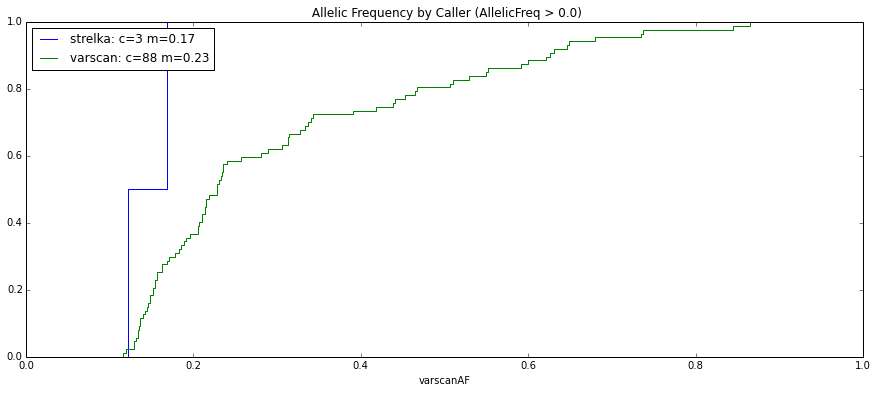

In [25]:
#snpdf = df[(df.variantType == 'SNP')&(df['filter'] == 'VarFreq')]
snpdf = df[(df.variantType == 'INDEL')&(df.consensus == True)&(df.inPON == False)]
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,1])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''

In [ ]:
# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"